<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/bert_movies_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(9)

import tensorflow as tf
from tensorflow import set_random_seed
import tensorflow_hub as hub
set_random_seed(9)

import tensorflow.keras
from tensorflow.keras import backend as K
from tqdm import tqdm_notebook
import re 

print(tf.__version__)

1.14.0-rc1


In [0]:
!pip install bert-tensorflow

In [0]:
!nvidia-smi

Sun Jun 23 14:02:08 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import glob

path = r'gdrive/My Drive/TFG/movies/' # use your path
all_files = glob.glob(path + "/*.csv")
print(len(all_files))

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, sep='|')
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

25


In [0]:
data = data.sort_values('id').reset_index(drop=True)

In [0]:
data = data.dropna(subset=['overview']).reset_index(drop=True)

In [0]:
len(data)

36544

In [0]:
data = data[~data['overview'].str.contains('Recuerda que puedes ver esta película')]
data = data[data.overview.str.len()>50].reset_index(drop=True)

In [0]:
data['overview'].str.len().describe().astype(int)

count    36430
mean       391
std        193
min         51
25%        246
50%        362
75%        504
max       1000
Name: overview, dtype: int64

In [0]:
df = data[['overview','genres']]

In [0]:
def eval_cell(cell):
  
  try:
    
    cell_array = eval(cell)
  
  except:
    
    cell_array = []
  
  return cell_array

def get_genres(cell):
  
  cell_array = eval_cell(cell)

  if len(cell_array)>0:
    ids_list = [v['name'] for v in cell_array]
    
  else:
    ids_list = []
  
  return ids_list

from sklearn.preprocessing import MultiLabelBinarizer

# Crate Dataframe with ids
def create_df_genres(ids,column_name):
  
  enc = MultiLabelBinarizer()
  np_ids = enc.fit_transform(ids)
  
  # Save encoder in a pickle
  
  column_names = []
  print('Num of '+ column_name + ': ' + str(len(enc.classes_)))
  
  for c in enc.classes_:
    column_names.append(str(c))
  
  df_ids = pd.DataFrame(data = np_ids, index=data.index, columns=column_names)
  
  return df_ids


# Merge dataframe ids with data
def merge_ids(data,column_name):

  ids = data[column_name].apply(lambda x: get_genres(x))
    
  df_ids = create_df_genres(ids,column_name)
  
  df = data.copy()
  df = df.join(df_ids)
  
  return df

In [0]:
df = merge_ids(df,'genres')

Num of genres: 19


In [0]:
df = df.drop(['genres','Película de TV'],axis=1)

In [0]:
sum_genres = df.iloc[:,-18:].sum(axis=0).astype(int).sort_values().to_dict()
print(sum_genres)

{'Historia': 1180, 'Música': 1180, 'Bélica': 1191, 'Western': 1374, 'Documental': 1459, 'Animación': 2096, 'Fantasía': 2105, 'Misterio': 2187, 'Familia': 2535, 'Ciencia ficción': 2718, 'Aventura': 3550, 'Crimen': 3645, 'Terror': 4254, 'Romance': 5312, 'Acción': 5893, 'Suspense': 6528, 'Comedia': 9776, 'Drama': 15968}


In [0]:
df['n_genres'] = df.iloc[:,-18:].sum(axis=1)
df = df[df['n_genres'] != 0].reset_index(drop=True)
df = df.iloc[:,:-1]

In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 1996)

In [0]:
from bert.tokenization import FullTokenizer

# Initialize session
sess = tf.Session()

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1"
max_seq_length = 256

In [0]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = train_df['overview'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_labels_ok = train_df.iloc[:,-18:].values

test_text = test_df['overview'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_labels_ok = test_df.iloc[:,-18:].values

In [0]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Instantiate tokenizer
tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_labels_ok)
test_examples = convert_text_to_examples(test_text, test_labels_ok)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=max_seq_length)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=max_seq_length)

W0623 14:02:21.320900 140215868315520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/bert/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
# entre el elif y else
# mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
# masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
#         tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
# input_mask = tf.cast(input_mask, tf.float32)
# pooled = masked_reduce_mean(result, input_mask)

class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="mean",
        bert_path="https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Convolution1D, MaxPooling1D, Input, Bidirectional
from tensorflow.keras.layers import Embedding,CuDNNLSTM, SpatialDropout1D, Reshape, Flatten, BatchNormalization,CuDNNGRU
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, Adagrad

def my_conv1d(kernel_size, layer, filters=10, strides=1, act='relu'):
  
  c1d = Conv1D(filters = filters, kernel_size = kernel_size, padding='valid', strides=strides, kernel_initializer='he_uniform')(layer)
  c1d = BatchNormalization()(c1d)
  c1d = Activation(act)(c1d)
  
  return c1d

def my_dense(neurons, ant, act='sigmoid', ini='glorot_uniform', reg=None):
  
  dense = Dense(neurons, kernel_initializer=ini,  kernel_regularizer=reg)(ant)
  dense = BatchNormalization()(dense)
  dense = Activation(act)(dense)
  
  return dense

In [0]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

from tensorflow.keras import activations 

#https://gist.github.com/iridiumblue/622a9525189d48e9c00659fea269bfa4

class AttentionWithContext(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False, **kwargs):

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        input_shape_list = input_shape.as_list()

        self.W = self.add_weight(shape=((input_shape_list[-1], input_shape_list[-1])),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape_list[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape_list[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape.as_list())

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.tensordot(x, self.W,axes=1)

        if self.bias:
            uit += self.b

        uit = activations.tanh(uit)
        # ait = K.dot(uit, self.u)
        ait = tf.tensordot(uit, self.u,axes=1)

        a = activations.exponential(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            #TODO use TensorShape here, as done in the else statement.   I'm not sure
            # if this is returning a single tensor, or a list of two so leaving this undone for now.  Suspect this will
            # need to complete if using Sequential rather than Functional API
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return tf.TensorShape([input_shape[0].value,input_shape[-1].value])


In [0]:
# Build model

#     pooled_output: pooled output of the entire sequence with shape [batch_size, hidden_size].
#     sequence_output: representations of every token in the input sequence with shape [batch_size, max_sequence_length, hidden_size].


def build_model(max_seq_length, gru, neurons, lr): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=0, pooling="mean")(bert_inputs)
    
    x = Bidirectional(CuDNNGRU(gru, kernel_initializer='glorot_uniform', return_sequences=True))(bert_output)
    x = BatchNormalization()(x)
    x = AttentionWithContext()(x)
    x = my_dense(neurons,x,act='relu', ini='he_uniform')
    x = my_dense(18,x,act='sigmoid')
    
    model = Model(inputs=bert_inputs, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy'])
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [0]:
model = build_model(max_seq_length,64,128,0.01)

# Instantiate variables
initialize_vars(sess)

history = model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels_ok,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels_ok),
    epochs=3,
    batch_size=64
)

W0623 15:58:46.516890 140215868315520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0623 15:58:46.518365 140215868315520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0623 15:58:46.519575 140215868315520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is de

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, None, 768)    178565115   input_ids[0][0]                  
                                                                 input_masks[0][0]          

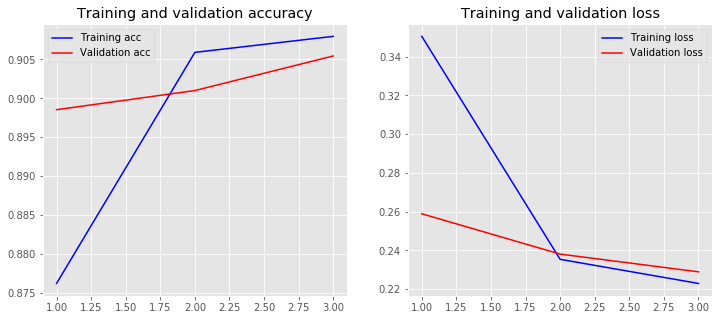

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [27]:
y_score = model.predict([test_input_ids[0:2000], test_input_masks[0:2000], test_segment_ids[0:2000]], verbose = 1)
threshold = 0.5

y_pred = y_score.copy()
y_pred[y_pred >=threshold] = 1
y_pred[y_pred <threshold] = 0

y_test = test_labels_ok[0:2000]

2000/2000 [==============================] - 41s 21ms/sample


In [29]:
labels_list = df.columns[-18:]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

for idx,label in enumerate(labels_list):
  print(label + '\n')
  print("Confusion Matrix: \n" + str(confusion_matrix(y_test[:,idx], y_pred[:,idx])))
  print("Accuracy: {:.4f}".format(accuracy_score(y_test[:,idx], y_pred[:,idx])))
  print("F1: {:.4f}".format(f1_score(y_test[:,idx], y_pred[:,idx],pos_label=1)))
  print("Auc: {:.4f}".format(roc_auc_score(y_test[:,idx], y_pred[:,idx])))
  print("-------------------------------------------------------------------")

Acción

Confusion Matrix: 
[[1504  134]
 [ 133  229]]
Accuracy: 0.8665
F1: 0.6317
Auc: 0.7754
-------------------------------------------------------------------
Animación

Confusion Matrix: 
[[1870    8]
 [  94   28]]
Accuracy: 0.9490
F1: 0.3544
Auc: 0.6126
-------------------------------------------------------------------
Aventura

Confusion Matrix: 
[[1732   76]
 [ 121   71]]
Accuracy: 0.9015
F1: 0.4189
Auc: 0.6639
-------------------------------------------------------------------
Bélica

Confusion Matrix: 
[[1938    1]
 [  46   15]]
Accuracy: 0.9765
F1: 0.3896
Auc: 0.6227
-------------------------------------------------------------------
Ciencia ficción

Confusion Matrix: 
[[1819   26]
 [  92   63]]
Accuracy: 0.9410
F1: 0.5164
Auc: 0.6962
-------------------------------------------------------------------
Comedia

Confusion Matrix: 
[[1376   53]
 [ 423  148]]
Accuracy: 0.7620
F1: 0.3834
Auc: 0.6111
-------------------------------------------------------------------
Crimen

Confu

In [0]:
model.save('my_BertModel.h5')

In [0]:
pre_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) # predictions before we clear and reload model

# Clear and load model
model = None
model = build_model(max_seq_length)
initialize_vars(sess)
model.load_weights('BertModel.h5')

post_save_preds = model.predict([test_input_ids[0:100], 
                                test_input_masks[0:100], 
                                test_segment_ids[0:100]]
                              ) # predictions after we clear and reload model
all(pre_save_preds == post_save_preds) # Are they the same?

